In [4]:
from environment import CoronagraphEnviroment
import hcipy
from hcipy import *
from matplotlib import pyplot as plt

In [5]:
e = CoronagraphEnviroment()

initializing coronagraph env. might take a minute.


NameError: name 'size' is not defined

[0. 0. 0. ... 0. 0. 0.]


C:\Users\alexe\AppData\Local\Temp\ipykernel_21088\2408453806.py:4: RuntimeWarning: divide by zero encountered in log
  imshow_field(np.log(e.get_camera_image()))


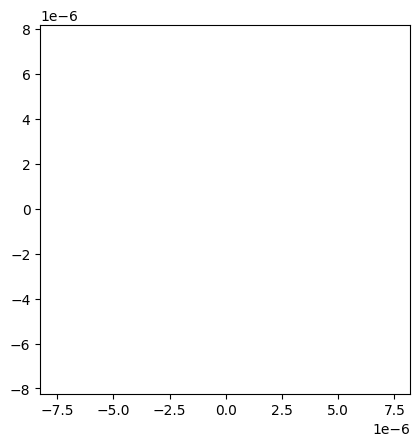

In [ ]:
import numpy as np

print(e.get_camera_image())
imshow_field(np.log(e.get_camera_image()))
plt.show()

In [ ]:
e.set_random_dm(noise=0.01)
plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')

clipped = np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None)

print(clipped.shape)
imshow_field(np.log(clipped), cmap='inferno')
plt.colorbar()
plt.show()

NameError: name 'e' is not defined

In [20]:
from tqdm import tqdm

# Build out a training dataset for a traditional CNN encoder.

# Example: Generate a dataset of N random DM settings and their corresponding images
N = 50000  # Number of samples
images = []
dm_settings = []

for _ in tqdm(range(N), desc="Building dataset"):
    e.set_random_dm(noise=0.001)
    images.append(np.log(np.clip(e.get_camera_image(), a_min = 1e-8, a_max = None)))
    dm_settings.append(e.get_perfect_adjustment()) 

# Normalize dm_settings to zero mean and unit variance
dm_settings = np.array(dm_settings)
dm_mean = dm_settings.mean(axis=0)
dm_std = dm_settings.std(axis=0)
dm_settings_norm = (dm_settings - dm_mean) / (dm_std + 1e-8)

Building dataset:  12%|█▏        | 5871/50000 [06:59<52:31, 14.00it/s]  


KeyboardInterrupt: 

In [27]:
from sklearn.model_selection import train_test_split

# Convert images (list of OldStyleField) to numpy arrays for ML usage
X = np.array([np.array(img).reshape(240, 240) for img in images[:2000]])  # shape: (N, 240, 240)
X = X[..., np.newaxis]  # shape: (N, 240, 240, 1) if needed for channels

# If you want to use 3 channels (like for ResNet), stack or repeat along channel axis
X = np.repeat(X, 3, axis=-1)  # shape: (N, 240, 240, 3)

# dm_settings_norm is already normalized and is the target
y = dm_settings_norm[:2000]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1]:
import torch

import torch.nn as nn
import torchvision.models as models

class LargeImageEncoderNet(nn.Module):
    def __init__(self, output_dim=500):
        super(LargeImageEncoderNet, self).__init__()
        # Use a pretrained ResNet50 as the encoder

        # A deep CNN with several convolutional and fully connected layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),  # (B,32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B,64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B,128,28,28)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (B,256,14,14)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (B,512,7,7)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Flatten(),  # (B,512*7*7)
            nn.Linear(512*7*7, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, output_dim)
        )

        
        # Replace the final fully connected layer to output a vector of size 500
        in_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        return self.encoder(x)
    
    

# Example usage:
# model = LargeImageEncoderNet(output_dim=500)
# output = model(torch.randn(1, 3, 224, 224))  # Example input

In [2]:
import torch.optim as optim
import torch.nn.functional as F

# Prepare data for training
# X_train shape: (N, 240, 240, 3) -> (N, 3, 240, 240)
X_train_torch = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Resize images to 224x224 for ResNet50
X_train_torch = F.interpolate(X_train_torch, size=(224, 224), mode='bilinear', align_corners=False)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LargeImageEncoderNet(output_dim=500).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

NameError: name 'X_train' is not defined

In [30]:
# Prepare test data: (N, 240, 240, 3) -> (N, 3, 240, 240) and resize to 224x224
X_test_torch = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
X_test_torch = F.interpolate(X_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Move to device
X_test_torch = X_test_torch.to(device)
y_test_torch = y_test_torch.to(device)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch)
    test_loss = criterion(y_pred, y_test_torch).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0023


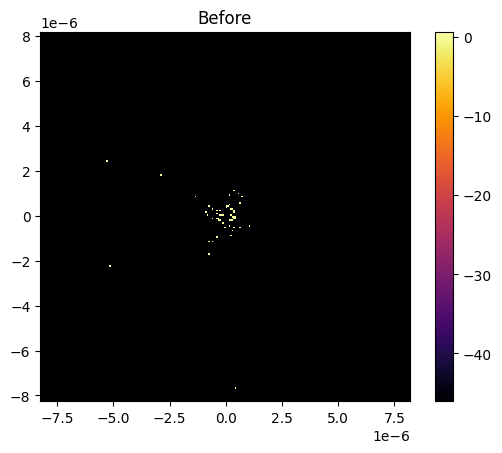

C:\Users\alexe\AppData\Local\Temp\ipykernel_21088\3332717008.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)


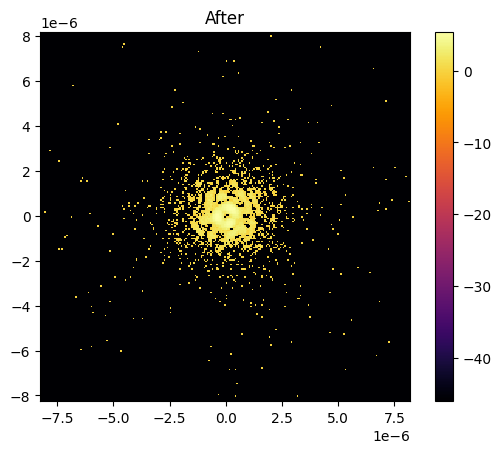

In [37]:
e.set_random_dm(noise=0.001)

plt.title('Before')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()

image = np.array([np.array(image[0]).reshape(240, 240)])

image = image[..., np.newaxis]
image = np.repeat(image, 3, axis=-1)

manual_test_torch = torch.tensor(image.transpose(0, 3, 1, 2), dtype=torch.float32)
manual_test_torch = F.interpolate(manual_test_torch, size=(224, 224), mode='bilinear', align_corners=False)
manual_test_torch = manual_test_torch.to(device)
with torch.no_grad():
    y_pred = model(manual_test_torch)

e.set_dm(np.array(y_pred[0].to('cpu')) * dm_std + dm_mean)

plt.title('After')
image = [np.log(np.clip(e.get_camera_image(), a_min = 10 ** -20, a_max = None))]

imshow_field(image[0], cmap='inferno')
plt.colorbar()
plt.show()


array([500])

In [ ]:
# Convert the log of the clipped image to a torch tensor and pass through the network
log_clipped = np.log(clipped)
# Reshape and normalize as needed for ResNet50 (expects 3x224x224 input)
log_clipped_img = log_clipped.reshape(240, 240)  # Assuming 240x240 image

# Convert to 3-channel by stacking, normalize to [0,1]
img_np = np.stack([log_clipped_img]*3, axis=0)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Resize to 224x224 for ResNet50
import torch.nn.functional as F
img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0)  # shape (1,3,240,240)
img_tensor = F.interpolate(img_tensor, size=(224,224), mode='bilinear', align_corners=False)

# Pass through the network
model = LargeImageEncoderNet(output_dim=500)
model.eval()
with torch.no_grad():
    output = model(img_tensor)
print(output)

a:\Projects\DM + RL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
a:\Projects\DM + RL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[-0.1284, -0.0586, -0.3857, -0.0490,  0.3105, -0.1154, -0.0051, -0.1131,
         -0.1875,  0.3061,  0.3255, -0.1176, -0.0098, -0.5990, -0.0594, -0.0030,
          0.0636,  0.1647,  0.1289, -0.0131, -0.1034,  0.3748, -0.0170, -0.0954,
          0.0900,  0.1548, -0.1167,  0.0522, -0.3127, -0.4427,  0.1683, -0.5318,
          0.1989,  0.1046, -0.1292,  0.5169, -0.4249, -0.0627,  0.0630, -0.2278,
          0.0517,  0.0906,  0.1015,  0.0506,  0.0849,  0.3059, -0.2986, -0.2387,
          0.1960, -0.3074,  0.2645, -0.0508, -0.2207, -0.0672,  0.0869,  0.2099,
         -0.3448,  0.0713, -0.2548, -0.1091, -0.2851, -0.0511, -0.0407, -0.0878,
         -0.3933, -0.0826, -0.1715, -0.1929,  0.0691,  0.1179,  0.1438,  0.1045,
         -0.5399,  0.5008, -0.0253, -0.1165, -0.1699,  0.1100, -0.2089, -0.1661,
          0.0460,  0.4235,  0.2166, -0.1098, -0.3527,  0.0979, -0.2749, -0.1874,
         -0.3185, -0.2087,  0.3945,  0.0108, -0.0677,  0.3757, -0.1646, -0.1902,
         -0.3802, -0.3508, -